In [47]:
import pandas as pd

# servers = ["1xCPU", "1xT4", "2xT4", "4xT4", "10xT4"]
# meas_dir = "/depot/cms/sonic/dkondra/saturation_measurements_nov2023/"
# n_jobs = [1,2,4,8,12,16,20,24,32,40,48,56,64]

servers = ["1xCPU", "1xT4", "2xT4", "4xT4", "linear"]
meas_dir = "/depot/cms/sonic/dkondra/saturation_measurements/"
# n_jobs = [1,5,10,15,20,25,30,40,60,80,100,150,200]
# n_jobs = [1,5,10,15,25,40,60,80,100,150,200]
# n_jobs = [1,2,5,10,15,20,25,30,40,50,60,80,100,150,200]
n_jobs = [1,2,5,10,15,20,25,30,40,50,60,80,100,150,160]


columns = servers + ["diff"]# + ["perfect"]
df = pd.DataFrame(columns=columns)
df.loc[0, :] = [0 for c in columns]
for server in servers:
    for i in n_jobs:
        filename = f"{meas_dir}/{server}/{i}.txt"
        try:
            if server=="linear":
                # df.loc[i, "linear"] = (df.loc[150, "1xCPU"]-df.loc[10, "1xCPU"])*i/(150-10)
                df.loc[i,"linear"] = 31
                df.loc[i,"diff"] = df.loc[i,"linear"]-df.loc[i,"1xCPU"]
                continue

            with open(filename, 'r') as file:
                values_list = [float(value.strip()) for value in file.readlines()]
                df.loc[i, server] = sum(values_list)
                # df.loc[i, "perfect"] = df.loc[1, server] * i
                #print(i, values_list)

        except Exception:
            print(f"Skip {filename}")
# df.loc[200, "1xCPU"] = 2*df.loc[100, "1xCPU"]
df.sort_index(inplace=True)
print(df)

Skip /depot/cms/sonic/dkondra/saturation_measurements//1xCPU/160.txt
Skip /depot/cms/sonic/dkondra/saturation_measurements//1xT4/160.txt
Skip /depot/cms/sonic/dkondra/saturation_measurements//2xT4/160.txt
Skip /depot/cms/sonic/dkondra/saturation_measurements//4xT4/160.txt
          1xCPU       1xT4       2xT4        4xT4 linear        diff
0             0          0          0           0      0           0
1      1.871555   0.761182    2.29444    1.678331     31   29.128445
2      2.572191   4.740106   4.831498    4.067932     31   28.427809
5      6.603112  11.210819  11.264313   11.232282     31   24.396888
10    14.058081  20.425811  21.376065   23.516103     31   16.941919
15    22.410275  26.393382  31.272555   34.666658     31    8.589725
20    31.168205  28.372958  38.587413   45.775559     31   -0.168205
25    40.469648  29.797331  45.535391   55.928399     31   -9.469648
30    48.740186   30.26221  49.443482   64.036442     31  -17.740186
40    65.705439  30.529321  54.162338

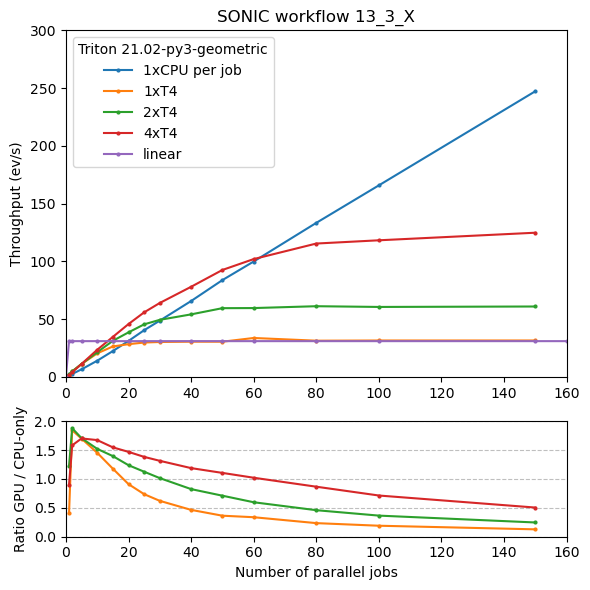

In [55]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = iter(colors)
color_dict = {}
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    gridspec_kw={'height_ratios': [3, 1]},
    figsize=(6, 6)
)

opts1 = {
    "marker": "o",
    "ms": 2,
}
opts2 = {
    "marker": "",
    "ms": 2,
    "linestyle": "--"
}
for server in servers:
    label = server
    if "CPU" in server:
        label = label+" per job"
    color = next(color_cycle)
    color_dict[server] = color
    ax1.plot(df.index, df[server], label=label, color=color, **opts1)

ax1.set_title("SONIC workflow 13_3_X")
# ax1.set_xlabel('Number of parallel jobs')
ax1.set_ylabel('Throughput (ev/s)')
ax1.set_xlim(0, max(n_jobs))
# plt.ylim(0, df.max().max()*1.05)
ax1.set_ylim(0, 300)
# plt.xscale('log')
ax1.legend(title="Triton 21.02-py3-geometric")
ax1.tick_params(axis='x', which='both', labelbottom=True)

div_by_cpu = True
for server in servers:
    if div_by_cpu:
        if "T4" in server:
            color = color_dict[server]
            mask = (df["1xCPU"] != 0)
            ratio = np.divide(df.loc[mask,server], df.loc[mask,"1xCPU"])
            # print(ratio)
            ax2.plot(df[mask].index, ratio, label=f"{server}", color=color, **opts1)
            ax2.set_ylabel('Ratio GPU / CPU-only')
            ax2.set_ylim(0, 2)
    else:
        df_ = df[1:]
        ratio = np.divide(df_[server], df_.index)
        ax2.plot(df[mask].index, ratio, label=f"{server}", **opts1)
        ax2.set_ylabel('Throuphput per job')
        ax2.set_ylim(0, 3)



ax2.set_xlabel('Number of parallel jobs')
ax2.yaxis.grid(True, linestyle='--', alpha=0.8)
# ax2.legend()

plt.tight_layout()
# plt.show()

from datetime import datetime
save_path = "/depot/cms/sonic/dkondra/sonic-studies/plots/"
datestamp = datetime.now().strftime("%d%b%Y")
filename = f"saturation_scan_{datestamp}.pdf"
plt.savefig(save_path+filename)